<a href="https://colab.research.google.com/github/sazio/NMAs/blob/main/Data_Loader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Exploratory Data Analysis of Stringer Dataset 
@authors: Simone Azeglio, Chetan Dhulipalla , Khalid Saifullah 


Part of the code here has been taken from [Neuromatch Academy's Computational Neuroscience Course](https://compneuro.neuromatch.io/projects/neurons/README.html), and specifically from [this notebook](https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/projects/neurons/load_stringer_spontaneous.ipynb)

# to do list

1. custom normalization: dividing by mean value per neuron
1a. downsampling: convolve then downsample by 5
2. training validation split: withhold last 20 percent of time series for testing
3. RNN for each layer: a way to capture the dynamics inside each layer instead of capturing extra dynamics from inter-layer interactions. it will be OK to compare the different RNNs. maintain same neuron count in each layer to reduce potential bias 
4. layer weight regularization: L2 
5. early stopping , dropout?

## Loading of Stringer spontaneous data



In [1]:
#@title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
    try:
        r = requests.get(url)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")
    else:
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
        else:
            with open(fname, "wb") as fid:
                fid.write(r.content)

In [2]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

## Exploratory Data Analysis (EDA)

In [3]:
#@title Data loading
import numpy as np
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


In [4]:
# functions 

def moving_avg(array, factor = 5):
    """Reducing the number of compontents by averaging of N = factor
    subsequent elements of array"""
    zeros_ = np.zeros((array.shape[0], 2))
    array = np.hstack((array, zeros_))

    array = np.reshape(array, (array.shape[0],  int(array.shape[1]/factor), factor))
    array = np.mean(array, axis = 2)

    return array

## Extracting Data for RNN (or LFADS)
The first problem to address is that for each layer we don't have the exact same number of neurons. We'd like to have a single RNN encoding all the different layers activities, to make it easier we can take the number of neurons ($N_{neurons} = 1131$ of the least represented class (layer) and level out each remaining class. 

In [5]:
# Extract labels from z - coordinate
from sklearn import preprocessing
x, y, z = dat['xyz']

le = preprocessing.LabelEncoder()
labels = le.fit_transform(z)
### least represented class (layer with less neurons)
n_samples = np.histogram(labels, bins=9)[0][-1]

In [6]:
### Data for LFADS / RNN 
import pandas as pd 
dataSet = pd.DataFrame(dat["sresp"])
dataSet["label"] = labels 

In [7]:
# it can be done in one loop ... 
data_ = []
for i in range(0, 9):
    data_.append(dataSet[dataSet["label"] == i].sample(n = n_samples).iloc[:,:-1])

dataRNN = np.zeros((n_samples*9, dataSet.shape[1]-1))
for i in range(0,9):
    
    # dataRNN[n_samples*i:n_samples*(i+1), :] = data_[i]
    ## normalized by layer
    dataRNN[n_samples*i:n_samples*(i+1), :] = data_[i]/np.mean(np.asarray(data_)[i,:,:], axis = 0)

## shuffling for training purposes

#np.random.shuffle(dataRNN)

In [8]:
#unshuffled = np.array(data_)

In [9]:
#@title Convolutions code

# convolution moving average

# kernel_length = 50
# averaging_kernel = np.ones(kernel_length) / kernel_length

# dataRNN.shape

# avgd_dataRNN = list()

# for neuron in dataRNN:
#   avgd_dataRNN.append(np.convolve(neuron, averaging_kernel))

# avg_dataRNN = np.array(avgd_dataRNN)

# print(avg_dataRNN.shape)

In [10]:
# @title Z Score Code 


# from scipy.stats import zscore


# neuron = 500

# scaled_all = zscore(avg_dataRNN)
# scaled_per_neuron = zscore(avg_dataRNN[neuron, :])

# scaled_per_layer = list()

# for layer in unshuffled:
#   scaled_per_layer.append(zscore(layer))

# scaled_per_layer = np.array(scaled_per_layer)



# plt.plot(avg_dataRNN[neuron, :])
# plt.plot(avg_dataRNN[2500, :])
# plt.figure()
# plt.plot(dataRNN[neuron, :])
# plt.figure()
# plt.plot(scaled_all[neuron, :])
# plt.plot(scaled_per_neuron)
# plt.figure()
# plt.plot(scaled_per_layer[0,neuron,:])


In [11]:
# custom normalization

normed_dataRNN = list()
for neuron in dataRNN:
    normed_dataRNN.append(neuron / neuron.mean())
normed_dataRNN = np.array(normed_dataRNN)

# downsampling and averaging 
#avgd_normed_dataRNN = dataRNN#
avgd_normed_dataRNN = moving_avg(dataRNN, factor=2)

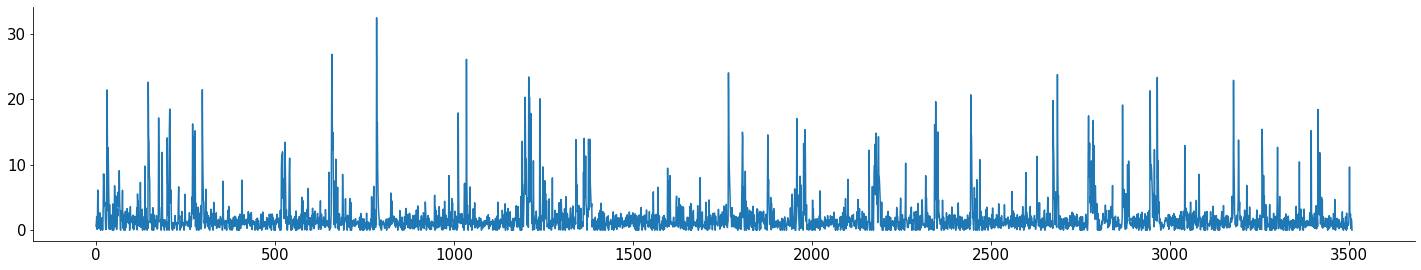

In [70]:
plt.plot(avgd_normed_dataRNN[0,:])

issue: does the individual scaling by layer introduce bias that may artificially increase performance of the network?

## Data Loader 


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
# set the seed
np.random.seed(42)

# number of neurons 
NN = dataRNN.shape[0]

In [16]:
# swapping the axes to maintain consistency with seq2seq notebook in the following code - the network takes all the neurons at a time step as input, not just one neuron

# avgd_normed_dataRNN = np.swapaxes(avgd_normed_dataRNN, 0, 1)
avgd_normed_dataRNN.shape

(10179, 3510)

In [17]:
frac = 4/5

#x1 = torch.from_numpy(dataRNN[:,:int(frac*dataRNN.shape[1])]).to(device).float().unsqueeze(0)
#x2 = torch.from_numpy(dataRNN[:,int(frac*dataRNN.shape[1]):]).to(device).float().unsqueeze(0)
#x1 = torch.from_numpy(avgd_normed_dataRNN[:1131,:]).to(device).float().unsqueeze(2)
#x2 = torch.from_numpy(avgd_normed_dataRNN[:1131,:]).to(device).float().unsqueeze(2)

n_neurs = 1131
# let's use n_neurs/10 latent components
ncomp = int(n_neurs/10)

x1_train = torch.from_numpy(avgd_normed_dataRNN[:n_neurs,:int(frac*avgd_normed_dataRNN.shape[1])]).to(device).float().unsqueeze(2)
x2_train = torch.from_numpy(avgd_normed_dataRNN[:n_neurs,:int(frac*avgd_normed_dataRNN.shape[1])]).to(device).float().unsqueeze(2)

x1_valid = torch.from_numpy(avgd_normed_dataRNN[:n_neurs,int(frac*avgd_normed_dataRNN.shape[1]):]).to(device).float().unsqueeze(2)
x2_valid = torch.from_numpy(avgd_normed_dataRNN[:n_neurs,int(frac*avgd_normed_dataRNN.shape[1]):]).to(device).float().unsqueeze(2)

NN1 = x1_train.shape[0]
NN2 = x2_train.shape[0]


In [23]:
class Net(nn.Module):
    def __init__(self, ncomp, NN1, NN2, bidi=True):
        super(Net, self).__init__()

        # play with some of the options in the RNN!
        
        self.rnn = nn.LSTM(NN1, ncomp, num_layers = 1, dropout = 0.,
                         bidirectional = bidi)
        """
        self.rnn = nn.RNN(NN1, ncomp, num_layers = 1, dropout = 0,
                    bidirectional = bidi, nonlinearity = 'tanh')
        self.rnn = nn.GRU(NN1, ncomp, num_layers = 1, dropout = 0,
                         bidirectional = bidi)
        """
        
        self.mlp = nn.Sequential(
                    nn.Linear(ncomp, ncomp*5),
                    nn.Mish(),
                    nn.Dropout(),
                    nn.Linear(ncomp*5, ncomp*5),
                    nn.Mish(),
                    nn.Dropout(),
                    nn.Linear(ncomp*5, ncomp), 
                    nn.Mish())
        
        self.fc = nn.Linear(ncomp, NN2)

    def forward(self, x):
        x = x.permute(1, 2, 0)
        #print(x.shape)
        # h_0 = torch.zeros(2, x.size()[1], self.ncomp).to(device)
        
        y, h_n = self.rnn(x)

        #print(y.shape)
        #print(h_n.shape)
        if self.rnn.bidirectional:
          # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
          # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
            q = (y[:, :, :ncomp] + y[:, :, ncomp:])/2
        else:
            q = y
        
        q = self.mlp(q)

        # the softplus function is just like a relu but it's smoothed out so we can't predict 0
        # if we predict 0 and there was a spike, that's an instant Inf in the Poisson log-likelihood which leads to failure
        #z = F.softplus(self.fc(q), 10)
        #print(q.shape)
        z = self.fc(q).permute(2, 0, 1)
        # print(z.shape)
        return z, q

In [24]:
# we initialize the neural network
net = Net(ncomp, NN1, NN2, bidi = True).to(device)

# special thing:  we initialize the biases of the last layer in the neural network
# we set them as the mean firing rates of the neurons.
# this should make the initial predictions close to the mean, because the latents don't contribute much
net.fc.bias.data[:] = x1_train.mean(axis = (0,1))

# we set up the optimizer. Adjust the learning rate if the training is slow or if it explodes.
optimizer1 = torch.optim.Adam(net.parameters(), lr=.0001)
# optimizer2 = torch.optim.SGD(net.parameters(), lr = 0.0001, momentum = 0.9, weight_decay = 0.01, )
# optimizer3 = torch.optim.

In [25]:
# forward check 
# net(x1)
net(x1_train)

(tensor([[[1.0131],
          [1.0212],
          [0.9929],
          ...,
          [1.0092],
          [1.0115],
          [1.0063]],
 
         [[1.0000],
          [1.0181],
          [1.0031],
          ...,
          [1.0078],
          [0.9966],
          [1.0138]],
 
         [[1.0182],
          [0.9884],
          [0.9692],
          ...,
          [0.9750],
          [0.9940],
          [0.9819]],
 
         ...,
 
         [[1.0058],
          [0.9883],
          [0.9935],
          ...,
          [1.0027],
          [1.0037],
          [1.0095]],
 
         [[0.9887],
          [0.9997],
          [1.0053],
          ...,
          [1.0220],
          [1.0117],
          [1.0217]],
 
         [[1.0134],
          [0.9839],
          [0.9923],
          ...,
          [1.0081],
          [0.9989],
          [0.9935]]], device='cuda:0', grad_fn=<PermuteBackward>),
 tensor([[[ 0.0335, -0.0194, -0.0217,  ..., -0.0175,  0.0311,  0.0022]],
 
         [[-0.0004,  0.0114, -0.0142,

## Training 

In [26]:
from tqdm import tqdm

In [74]:
from sam import SAM

base_optimizer = torch.optim.Adam  # define an optimizer for the "sharpness-aware" update
optimizer = SAM(net.parameters(), base_optimizer, lr=0.001)#, momentum=0.9)

# you can keep re-running this cell if you think the cost might decrease further

cost = nn.MSELoss()

train_save = []
valid_save = []

niter =  5500 # + 5800
# rnn_loss = 0.2372, lstm_loss = 0.2340, gru_lstm = 0.2370
for k in tqdm(range(niter)):
    net.train()
    # the network outputs the single-neuron prediction and the latents
    z, y = net(x1_train)

    # our cost
    loss = cost(z, x2_train)

    # train the network as usual
    loss.backward()
    optimizer.first_step(zero_grad = True)
    
    cost(net(x1_train)[0],x2_train).backward()
    
    optimizer.second_step(zero_grad=True)
    
    with torch.no_grad():
        net.eval()
        train_save.append(loss.item())
        valid_loss = cost(net(x1_valid)[0], x2_valid)
        valid_save.append(valid_loss.item())

    if k % 50 == 0:
        with torch.no_grad():
            net.eval()
            valid_loss = cost(net(x1_valid)[0], x2_valid)
            
            print(f' iteration {k}, train cost {loss.item():.4f}, valid cost {valid_loss.item():.4f}')

  0%|          | 2/5500 [00:00<18:10,  5.04it/s]

 iteration 0, train cost 0.6084, valid cost 1.1368


  1%|          | 52/5500 [00:08<15:12,  5.97it/s]

 iteration 50, train cost 0.6100, valid cost 0.8574


  2%|▏         | 102/5500 [00:17<15:08,  5.94it/s]

 iteration 100, train cost 0.6077, valid cost 0.8563


  3%|▎         | 152/5500 [00:25<14:56,  5.96it/s]

 iteration 150, train cost 0.6073, valid cost 0.8550


  4%|▎         | 202/5500 [00:33<14:48,  5.96it/s]

 iteration 200, train cost 0.6065, valid cost 0.8556


  5%|▍         | 252/5500 [00:42<14:38,  5.97it/s]

 iteration 250, train cost 0.6091, valid cost 0.8560


  5%|▌         | 302/5500 [00:50<14:22,  6.03it/s]

 iteration 300, train cost 0.6076, valid cost 0.8558


  6%|▋         | 352/5500 [00:58<14:26,  5.94it/s]

 iteration 350, train cost 0.6073, valid cost 0.8569


  7%|▋         | 402/5500 [01:07<14:14,  5.97it/s]

 iteration 400, train cost 0.6072, valid cost 0.8554


  8%|▊         | 452/5500 [01:15<14:07,  5.95it/s]

 iteration 450, train cost 0.6077, valid cost 0.8575


  9%|▉         | 502/5500 [01:23<13:59,  5.95it/s]

 iteration 500, train cost 0.6091, valid cost 0.8578


 10%|█         | 552/5500 [01:31<13:48,  5.97it/s]

 iteration 550, train cost 0.6077, valid cost 0.8573


 11%|█         | 602/5500 [01:40<13:37,  5.99it/s]

 iteration 600, train cost 0.6077, valid cost 0.8573


 12%|█▏        | 652/5500 [01:48<13:32,  5.97it/s]

 iteration 650, train cost 0.6076, valid cost 0.8568


 13%|█▎        | 702/5500 [01:57<13:45,  5.81it/s]

 iteration 700, train cost 0.6084, valid cost 0.8571


 14%|█▎        | 752/5500 [02:05<13:20,  5.93it/s]

 iteration 750, train cost 0.6068, valid cost 0.8563


 15%|█▍        | 802/5500 [02:13<13:08,  5.96it/s]

 iteration 800, train cost 0.6073, valid cost 0.8573


 15%|█▌        | 852/5500 [02:22<13:05,  5.91it/s]

 iteration 850, train cost 0.6065, valid cost 0.8576


 16%|█▋        | 902/5500 [02:30<12:55,  5.93it/s]

 iteration 900, train cost 0.6052, valid cost 0.8587


 17%|█▋        | 952/5500 [02:38<12:51,  5.90it/s]

 iteration 950, train cost 0.6081, valid cost 0.8579


 18%|█▊        | 1002/5500 [02:47<12:28,  6.01it/s]

 iteration 1000, train cost 0.6073, valid cost 0.8571


 19%|█▉        | 1052/5500 [02:55<12:17,  6.03it/s]

 iteration 1050, train cost 0.6079, valid cost 0.8575


 20%|██        | 1102/5500 [03:03<11:53,  6.17it/s]

 iteration 1100, train cost 0.6076, valid cost 0.8589


 21%|██        | 1152/5500 [03:11<11:47,  6.15it/s]

 iteration 1150, train cost 0.6080, valid cost 0.8574


 22%|██▏       | 1202/5500 [03:19<11:39,  6.15it/s]

 iteration 1200, train cost 0.6057, valid cost 0.8570


 23%|██▎       | 1252/5500 [03:27<11:30,  6.15it/s]

 iteration 1250, train cost 0.6074, valid cost 0.8591


 24%|██▎       | 1302/5500 [03:35<11:22,  6.15it/s]

 iteration 1300, train cost 0.6063, valid cost 0.8587


 25%|██▍       | 1352/5500 [03:43<11:14,  6.15it/s]

 iteration 1350, train cost 0.6060, valid cost 0.8596


 25%|██▌       | 1402/5500 [03:51<11:05,  6.15it/s]

 iteration 1400, train cost 0.6078, valid cost 0.8579


 26%|██▋       | 1452/5500 [04:00<11:00,  6.13it/s]

 iteration 1450, train cost 0.6059, valid cost 0.8578


 27%|██▋       | 1502/5500 [04:08<10:51,  6.14it/s]

 iteration 1500, train cost 0.6070, valid cost 0.8583


 28%|██▊       | 1552/5500 [04:16<10:42,  6.14it/s]

 iteration 1550, train cost 0.6066, valid cost 0.8590


 29%|██▉       | 1602/5500 [04:24<10:38,  6.10it/s]

 iteration 1600, train cost 0.6069, valid cost 0.8586


 30%|███       | 1652/5500 [04:32<10:29,  6.12it/s]

 iteration 1650, train cost 0.6071, valid cost 0.8582


 31%|███       | 1702/5500 [04:40<10:22,  6.10it/s]

 iteration 1700, train cost 0.6077, valid cost 0.8593


 32%|███▏      | 1752/5500 [04:48<10:12,  6.12it/s]

 iteration 1750, train cost 0.6072, valid cost 0.8593


 33%|███▎      | 1802/5500 [04:56<10:05,  6.10it/s]

 iteration 1800, train cost 0.6060, valid cost 0.8584


 34%|███▎      | 1852/5500 [05:04<09:56,  6.12it/s]

 iteration 1850, train cost 0.6069, valid cost 0.8584


 35%|███▍      | 1902/5500 [05:12<09:44,  6.16it/s]

 iteration 1900, train cost 0.6074, valid cost 0.8596


 35%|███▌      | 1952/5500 [05:20<09:36,  6.16it/s]

 iteration 1950, train cost 0.6052, valid cost 0.8586


 36%|███▋      | 2002/5500 [05:28<09:26,  6.17it/s]

 iteration 2000, train cost 0.6058, valid cost 0.8590


 37%|███▋      | 2052/5500 [05:36<09:18,  6.17it/s]

 iteration 2050, train cost 0.6062, valid cost 0.8591


 38%|███▊      | 2102/5500 [05:45<09:10,  6.17it/s]

 iteration 2100, train cost 0.6074, valid cost 0.8592


 39%|███▉      | 2152/5500 [05:53<09:01,  6.18it/s]

 iteration 2150, train cost 0.6065, valid cost 0.8593


 40%|████      | 2202/5500 [06:01<08:56,  6.15it/s]

 iteration 2200, train cost 0.6065, valid cost 0.8595


 41%|████      | 2252/5500 [06:09<08:46,  6.17it/s]

 iteration 2250, train cost 0.6068, valid cost 0.8594


 42%|████▏     | 2302/5500 [06:17<08:37,  6.18it/s]

 iteration 2300, train cost 0.6069, valid cost 0.8580


 43%|████▎     | 2352/5500 [06:25<08:31,  6.15it/s]

 iteration 2350, train cost 0.6057, valid cost 0.8606


 44%|████▎     | 2402/5500 [06:33<08:20,  6.19it/s]

 iteration 2400, train cost 0.6080, valid cost 0.8589


 45%|████▍     | 2452/5500 [06:41<08:12,  6.19it/s]

 iteration 2450, train cost 0.6060, valid cost 0.8608


 45%|████▌     | 2502/5500 [06:49<08:04,  6.18it/s]

 iteration 2500, train cost 0.6069, valid cost 0.8605


 46%|████▋     | 2552/5500 [06:57<08:00,  6.14it/s]

 iteration 2550, train cost 0.6056, valid cost 0.8593


 47%|████▋     | 2602/5500 [07:05<07:48,  6.18it/s]

 iteration 2600, train cost 0.6063, valid cost 0.8604


 48%|████▊     | 2652/5500 [07:13<07:59,  5.94it/s]

 iteration 2650, train cost 0.6068, valid cost 0.8595


 49%|████▉     | 2702/5500 [07:21<07:55,  5.88it/s]

 iteration 2700, train cost 0.6065, valid cost 0.8591


 50%|█████     | 2752/5500 [07:30<07:44,  5.91it/s]

 iteration 2750, train cost 0.6061, valid cost 0.8597


 51%|█████     | 2802/5500 [07:38<07:18,  6.15it/s]

 iteration 2800, train cost 0.6063, valid cost 0.8603


 52%|█████▏    | 2852/5500 [07:46<07:12,  6.12it/s]

 iteration 2850, train cost 0.6058, valid cost 0.8609


 53%|█████▎    | 2902/5500 [07:54<07:03,  6.13it/s]

 iteration 2900, train cost 0.6061, valid cost 0.8605


 54%|█████▎    | 2952/5500 [08:02<06:55,  6.14it/s]

 iteration 2950, train cost 0.6068, valid cost 0.8602


 55%|█████▍    | 3002/5500 [08:10<06:49,  6.09it/s]

 iteration 3000, train cost 0.6056, valid cost 0.8607


 55%|█████▌    | 3052/5500 [08:18<06:47,  6.01it/s]

 iteration 3050, train cost 0.6047, valid cost 0.8607


 56%|█████▋    | 3102/5500 [08:27<06:31,  6.13it/s]

 iteration 3100, train cost 0.6059, valid cost 0.8598


 57%|█████▋    | 3152/5500 [08:35<06:30,  6.01it/s]

 iteration 3150, train cost 0.6066, valid cost 0.8605


 58%|█████▊    | 3202/5500 [08:43<06:16,  6.10it/s]

 iteration 3200, train cost 0.6058, valid cost 0.8607


 59%|█████▉    | 3252/5500 [08:51<06:09,  6.08it/s]

 iteration 3250, train cost 0.6051, valid cost 0.8613


 60%|██████    | 3302/5500 [08:59<05:58,  6.13it/s]

 iteration 3300, train cost 0.6052, valid cost 0.8618


 61%|██████    | 3352/5500 [09:07<05:48,  6.16it/s]

 iteration 3350, train cost 0.6037, valid cost 0.8618


 62%|██████▏   | 3402/5500 [09:15<05:45,  6.08it/s]

 iteration 3400, train cost 0.6045, valid cost 0.8615


 63%|██████▎   | 3452/5500 [09:23<05:36,  6.08it/s]

 iteration 3450, train cost 0.6053, valid cost 0.8612


 64%|██████▎   | 3502/5500 [09:32<05:31,  6.02it/s]

 iteration 3500, train cost 0.6048, valid cost 0.8623


 65%|██████▍   | 3552/5500 [09:40<05:26,  5.97it/s]

 iteration 3550, train cost 0.6045, valid cost 0.8630


 65%|██████▌   | 3602/5500 [09:48<05:07,  6.18it/s]

 iteration 3600, train cost 0.6049, valid cost 0.8623


 66%|██████▋   | 3652/5500 [09:56<04:59,  6.17it/s]

 iteration 3650, train cost 0.6040, valid cost 0.8615


 67%|██████▋   | 3702/5500 [10:04<04:57,  6.05it/s]

 iteration 3700, train cost 0.6069, valid cost 0.8625


 68%|██████▊   | 3752/5500 [10:12<04:50,  6.02it/s]

 iteration 3750, train cost 0.6054, valid cost 0.8626


 69%|██████▉   | 3802/5500 [10:20<04:36,  6.14it/s]

 iteration 3800, train cost 0.6051, valid cost 0.8624


 70%|███████   | 3852/5500 [10:29<04:29,  6.11it/s]

 iteration 3850, train cost 0.6054, valid cost 0.8626


 71%|███████   | 3902/5500 [10:37<04:22,  6.10it/s]

 iteration 3900, train cost 0.6054, valid cost 0.8609


 72%|███████▏  | 3952/5500 [10:45<04:12,  6.14it/s]

 iteration 3950, train cost 0.6051, valid cost 0.8625


 73%|███████▎  | 4002/5500 [10:53<04:10,  5.97it/s]

 iteration 4000, train cost 0.6057, valid cost 0.8634


 74%|███████▎  | 4052/5500 [11:01<04:07,  5.85it/s]

 iteration 4050, train cost 0.6047, valid cost 0.8619


 75%|███████▍  | 4102/5500 [11:10<03:56,  5.91it/s]

 iteration 4100, train cost 0.6045, valid cost 0.8619


 75%|███████▌  | 4152/5500 [11:18<03:39,  6.14it/s]

 iteration 4150, train cost 0.6044, valid cost 0.8625


 76%|███████▋  | 4202/5500 [11:26<03:37,  5.97it/s]

 iteration 4200, train cost 0.6059, valid cost 0.8622


 77%|███████▋  | 4252/5500 [11:34<03:27,  6.02it/s]

 iteration 4250, train cost 0.6040, valid cost 0.8627


 78%|███████▊  | 4302/5500 [11:42<03:18,  6.04it/s]

 iteration 4300, train cost 0.6047, valid cost 0.8643


 79%|███████▉  | 4352/5500 [11:51<03:15,  5.86it/s]

 iteration 4350, train cost 0.6044, valid cost 0.8634


 80%|████████  | 4402/5500 [11:59<03:05,  5.93it/s]

 iteration 4400, train cost 0.6051, valid cost 0.8643


 81%|████████  | 4452/5500 [12:07<02:57,  5.92it/s]

 iteration 4450, train cost 0.6060, valid cost 0.8631


 82%|████████▏ | 4501/5500 [12:15<02:43,  6.12it/s]

 iteration 4500, train cost 0.6052, valid cost 0.8623


 83%|████████▎ | 4552/5500 [12:27<02:37,  6.02it/s]

 iteration 4550, train cost 0.6034, valid cost 0.8635


 84%|████████▎ | 4602/5500 [12:35<02:32,  5.88it/s]

 iteration 4600, train cost 0.6037, valid cost 0.8641


 85%|████████▍ | 4652/5500 [12:43<02:24,  5.87it/s]

 iteration 4650, train cost 0.6041, valid cost 0.8643


 85%|████████▌ | 4702/5500 [12:52<02:12,  6.03it/s]

 iteration 4700, train cost 0.6043, valid cost 0.8642


 86%|████████▋ | 4752/5500 [13:00<02:03,  6.08it/s]

 iteration 4750, train cost 0.6046, valid cost 0.8638


 87%|████████▋ | 4802/5500 [13:08<01:53,  6.17it/s]

 iteration 4800, train cost 0.6039, valid cost 0.8647


 88%|████████▊ | 4852/5500 [13:16<01:46,  6.07it/s]

 iteration 4850, train cost 0.6030, valid cost 0.8633


 89%|████████▉ | 4902/5500 [13:24<01:38,  6.08it/s]

 iteration 4900, train cost 0.6041, valid cost 0.8640


 90%|█████████ | 4952/5500 [13:32<01:31,  6.01it/s]

 iteration 4950, train cost 0.6028, valid cost 0.8635


 91%|█████████ | 5002/5500 [13:40<01:22,  6.02it/s]

 iteration 5000, train cost 0.6039, valid cost 0.8633


 92%|█████████▏| 5052/5500 [13:49<01:12,  6.14it/s]

 iteration 5050, train cost 0.6039, valid cost 0.8637


 93%|█████████▎| 5102/5500 [13:57<01:05,  6.08it/s]

 iteration 5100, train cost 0.6046, valid cost 0.8651


 94%|█████████▎| 5152/5500 [14:05<00:57,  6.05it/s]

 iteration 5150, train cost 0.6040, valid cost 0.8631


 95%|█████████▍| 5202/5500 [14:13<00:49,  6.07it/s]

 iteration 5200, train cost 0.6041, valid cost 0.8627


 95%|█████████▌| 5252/5500 [14:21<00:40,  6.11it/s]

 iteration 5250, train cost 0.6043, valid cost 0.8643


 96%|█████████▋| 5302/5500 [14:29<00:32,  6.04it/s]

 iteration 5300, train cost 0.6039, valid cost 0.8644


 97%|█████████▋| 5352/5500 [14:38<00:24,  6.14it/s]

 iteration 5350, train cost 0.6018, valid cost 0.8637


 98%|█████████▊| 5402/5500 [14:46<00:16,  6.09it/s]

 iteration 5400, train cost 0.6035, valid cost 0.8639


 99%|█████████▉| 5452/5500 [14:54<00:07,  6.02it/s]

 iteration 5450, train cost 0.6022, valid cost 0.8649


100%|██████████| 5500/5500 [15:02<00:00,  6.10it/s]


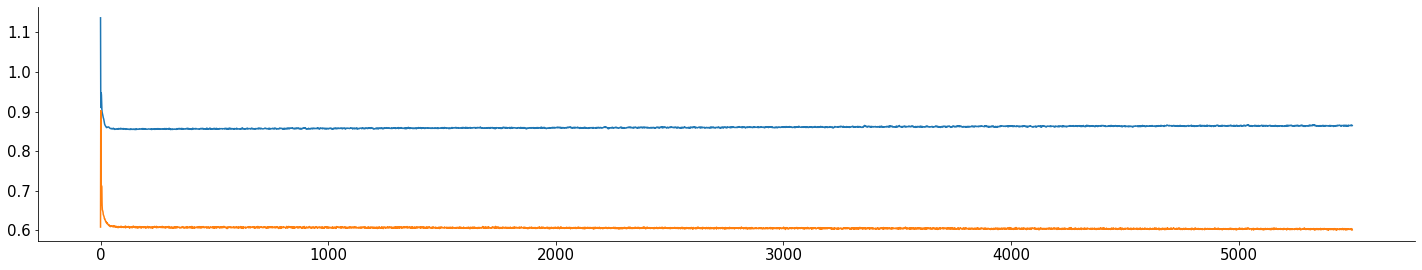

In [79]:
plt.plot(valid_save)
plt.plot(loss_save)

In [64]:
"""
### Original training
# you can keep re-running this cell if you think the cost might decrease further

cost = nn.MSELoss()

niter = 5800
# rnn_loss = 0.2372, lstm_loss = 0.2340, gru_lstm = 0.2370
for k in tqdm(range(niter)):
    net.train()
    # the network outputs the single-neuron prediction and the latents
    z, y = net(x1_train)

    # our cost
    loss = cost(z, x2_train)

    # train the network as usual
    loss.backward()
    optimizer1.step()
    optimizer1.zero_grad()
    

    if k % 50 == 0:
        with torch.no_grad():
            net.eval()
            valid_loss = cost(net(x1_valid)[0], x2_valid)
            
            print(f' iteration {k}, train cost {loss.item():.4f}, valid cost {valid_loss.item():.4f}')

""";  

## Validation from same neurons

In [65]:
test, hidden = net(x1_valid)

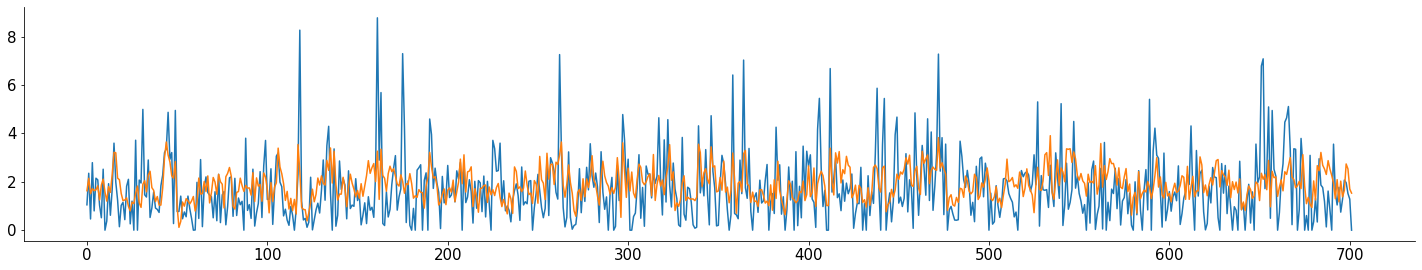

In [73]:
plt.plot(x2_valid[7,:,0].cpu().detach().numpy())
plt.plot(test[7,:,0].cpu().detach().numpy())

## Testing neurons from same layer

In [41]:
test, hidden = net(torch.from_numpy(avgd_normed_dataRNN[n_neurs:2*n_neurs,:]).unsqueeze(2).to(device).float())

In [43]:
test.shape

torch.Size([1131, 3510, 1])

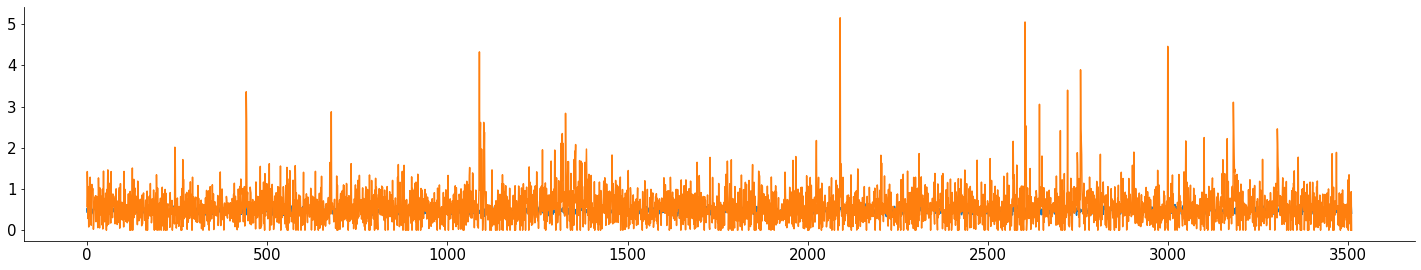

In [47]:
n_n = 15
plt.plot(test[n_n,:,0].cpu().detach().numpy())
plt.plot(avgd_normed_dataRNN[n_neurs + n_n,:])

## Testing neurons from another layer (#9)

In [ ]:
test, hidden = net(torch.from_numpy(avgd_normed_dataRNN[10000:10100,:]).unsqueeze(2).to(device).float())

In [ ]:
plt.plot(test[10,:,0].cpu().detach().numpy())
plt.plot(avgd_normed_dataRNN[10010,:])

# Training 9 Networks 
Each Network corresponds to a different layer in V1

In [ ]:
# you can keep re-running this cell if you think the cost might decrease further

cost = nn.MSELoss()

niter = 10000
# rnn_loss = 0.2372, lstm_loss = 0.2340, gru_lstm = 0.2370
for k in tqdm(range(niter)):
    net.train()
    # the network outputs the single-neuron prediction and the latents
    z, y = net(x1_train)

    # our cost
    loss = cost(z, x2_train)

    # train the network as usual
    loss.backward()
    optimizer1.step()
    optimizer1.zero_grad()

    if k % 50 == 0:
        with torch.no_grad():
            net.eval()
            valid_loss = cost(net(x1_valid)[0], x2_valid)
            
            print(f' iteration {k}, train cost {loss.item():.4f}, valid cost {valid_loss.item():.4f}')

    